In [2]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statistics import mode 



In [2]:
!pip install bottleneck
!pip install ruptures

You should consider upgrading via the 'C:\Users\rajsu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\rajsu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from GestureRecognitionDataset import GestureRecognitionDataset
gr = GestureRecognitionDataset("C:/Users/rajsu/Documents/iLimb/DataCollection/data", version = "v2", remove_transition=False)


In [3]:
dfv2 = gr.get_features()

  0%|          | 0/1148 [00:00<?, ?it/s]

100%|██████████| 1148/1148 [01:04<00:00, 17.78it/s]


In [4]:
gr = GestureRecognitionDataset("../data/dataJoel", version = "v1", remove_transition=True)
dfv1 = gr.get_features()

100%|██████████| 192/192 [00:19<00:00,  9.61it/s]


In [3]:
# imports
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from imblearn.under_sampling import RandomUnderSampler
from GestureRecognitionModel import GestureRecognitionModel

gestures_to_use = ["ClosedHand", "Neutral", "OpenHand", 
                "WristSupination", "WristPronation",
                "ThumbAbduction", "ThumbAdduction",
                "Pinch", "Lateral", "Point"]   # "Pinch", "Lateral", "Tripod", "Point"
individual = True
version = "v2"

# load dataset 
dfv1 = pd.read_csv(f"../data/features_v1.csv")
dfv2 =  pd.read_csv(f"../data/features_{version}.csv")

In [4]:
dfv2 = gr.timestamp_to_iter(dfv2)

NameError: name 'gr' is not defined

In [77]:
dfv2.columns

Index(['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7', 'gesture', 'subject', 'take', 'iteration'],
      dtype='object')

In [13]:
dfv1 = dfv1[['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7', 'gesture', 'subject', 'take']]
dfv2 = dfv2[['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7', 'gesture', 'subject', 'take']]


In [7]:
dfv2["gesture"] = [i if i!="rest_202" else "rest" for i in dfv2["gesture"]]
dfv2.gesture.unique()

array(['rest', 'thumb_abd', 'hand_close', 'hand_neutral', 'hand_open',
       'lateral', 'pinch', 'point', 'thumb_add', 'wrist_pron',
       'wrist_supin', 'tripod'], dtype=object)

In [8]:
dfv2.gesture.value_counts()

hand_neutral    18239
thumb_abd        6874
hand_open        6406
hand_close       6397
wrist_supin      5771
wrist_pron       5302
thumb_add        5175
pinch            4654
lateral          4132
point            4043
tripod           2744
rest              935
Name: gesture, dtype: int64

In [8]:
gestures_to_keep_v2 = ["hand_neutral", "hand_open", "hand_close", "wrist_supin", "wrist_pron"]
dfv2 = dfv2[dfv2["gesture"].isin(gestures_to_keep_v2)]

In [9]:
gestures_to_remove_v1 = ["Neutral", "OpenHand", "ClosedHand", "WristSupination", "WristPronation"]
dfv1 = dfv1[~dfv1["gesture"].isin(gestures_to_remove_v1)]


In [9]:
dfv2.subject.unique()

array(['David', 'Flex', 'Joel', 'JoelNew', 'Mario', 'PCTest', 'Raj', 'Up'],
      dtype=object)

In [10]:
subjects_to_keep = [ 'Raj']
dfv2 = dfv2[dfv2["subject"].isin(subjects_to_keep)]

In [146]:
dfv2.gesture.value_counts()

hand_neutral    5793
thumb_abd       2057
pinch           1940
thumb_add       1889
hand_close      1876
wrist_supin     1868
hand_open       1866
wrist_pron      1745
lateral         1688
tripod          1623
point           1562
Name: gesture, dtype: int64

In [11]:
df = dfv2
df.subject.unique()

array(['Raj'], dtype=object)

In [12]:
gestures_to_use =  ["hand_close",  "hand_open", 
                    "wrist_supin", "wrist_pron",
                    "thumb_abd", "thumb_add",
                    "pinch", "lateral", "point"]

In [13]:
columns_to_use = ['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7']

In [14]:
# measure distance between gestures 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



g_dist = {}
for gesture in gestures_to_use:
    
    df_sub = df[df.gesture == gesture][columns_to_use]
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df_sub)

    # Create a PCA instance: pca
    pca = PCA(n_components=1)  # n_components is the number of components to keep

    # Fit and transform the data
    pca_result = pca.fit_transform(scaled_df.T)

    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1'])

    g_dist[gesture] = pca_df['PCA1']


In [151]:
g_dist['hand_close']

0    31.096305
1    21.429306
2     7.942332
3     9.309339
4   -28.426239
5   -11.219805
6   -15.860011
7   -14.271226
Name: PCA1, dtype: float64

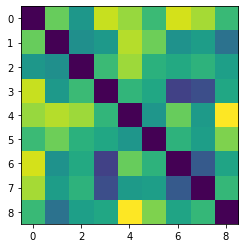

In [152]:
from scipy.spatial.distance import jensenshannon
dist_matrix = np.zeros((len(g_dist.keys()), len(g_dist.keys())))
for i, gesture1 in enumerate(g_dist.keys()):
    for j, gesture2 in enumerate(g_dist.keys()):
        dist_matrix[i, j] = np.sqrt(np.sum((g_dist[gesture1] - g_dist[gesture2])**2))

plt.imshow(dist_matrix)

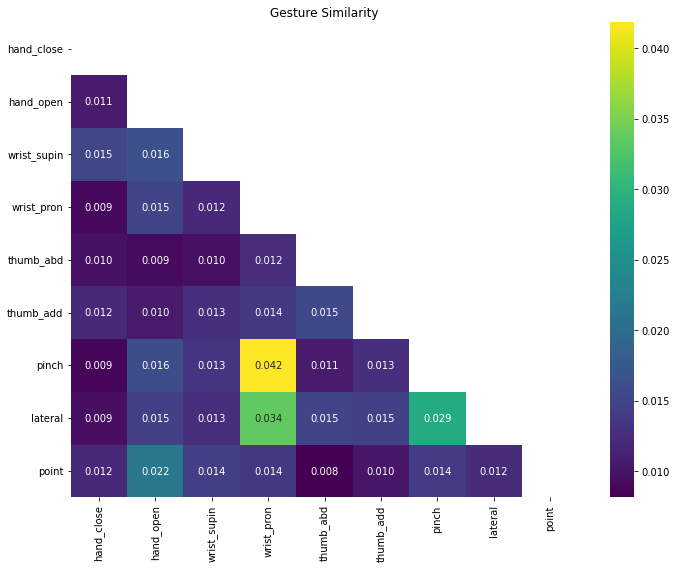

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(dist_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(1/(dist_matrix + 0.001),  mask = mask, annot=True, fmt=".3f", xticklabels=g_dist.keys(), yticklabels=g_dist.keys(), cmap='viridis')

# Add title and adjust layout
plt.title('Gesture Similarity')
plt.tight_layout()

# Show the plot
plt.show()


In [154]:
# TSNE 
from sklearn.manifold import TSNE
X = df[columns_to_use].to_numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_embedded.shape

(23907, 2)

<AxesSubplot:>

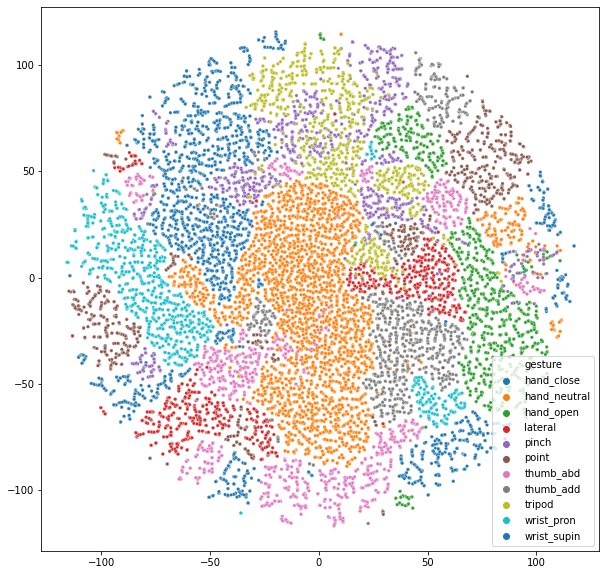

In [155]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = X_embedded[:, 0], y = X_embedded[:, 1], hue=df.gesture, s = 10, palette='tab10')

In [15]:
df[columns_to_use].columns

Index(['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7'], dtype='object')

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = df[columns_to_use]

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


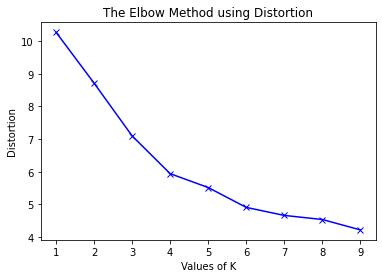

In [166]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Gesture: hand_close

Gesture: hand_open

Gesture: wrist_supin

Gesture: wrist_pron

Gesture: thumb_abd

Gesture: thumb_add

Gesture: pinch

Gesture: lateral

Gesture: point



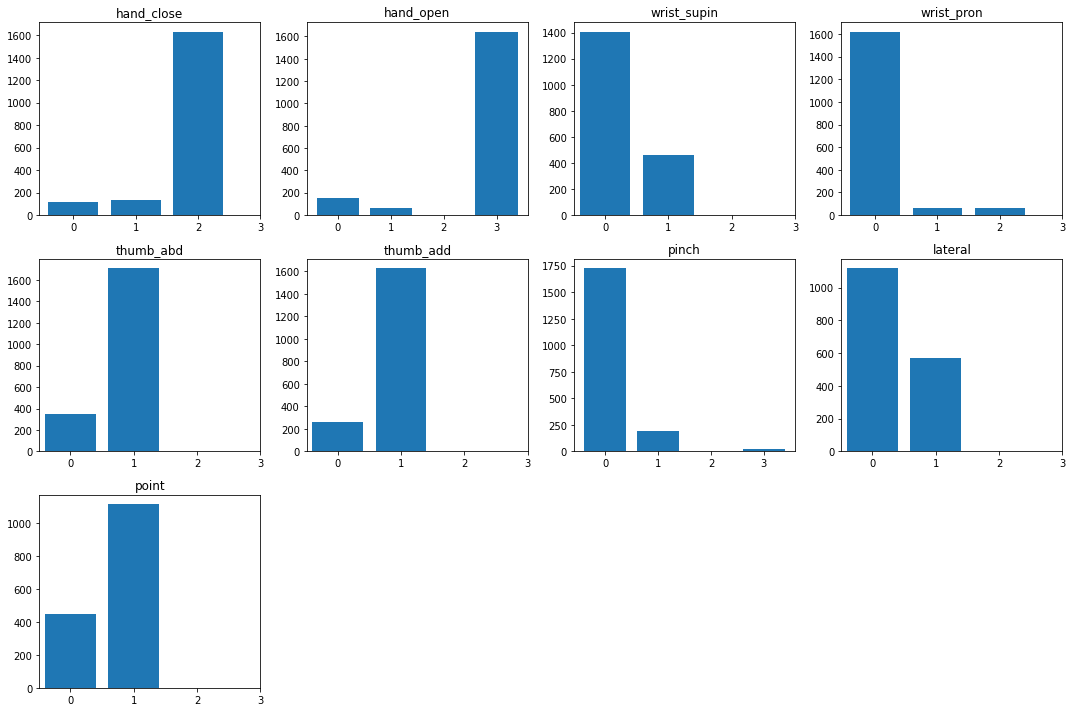

: 

In [36]:
# Fitting Model
model = KMeans(n_clusters=4)
model.fit(df[columns_to_use])
clusters = model.predict(df[columns_to_use])

df["cluster"] = clusters
plt.figure(figsize = (15, 10))
for i, gesture in enumerate(gestures_to_use):
    df_sub = df[df.gesture == gesture]
    print(f"Gesture: {gesture}\n")
    plt.subplot(3, 4, i+1)
    plt.bar(df_sub.cluster.unique(), df_sub.cluster.value_counts())
    plt.title(gesture)
    plt.xticks([0, 1, 2, 3], [0, 1, 2, 3])
plt.tight_layout()

models to train - 
- neutral vs gesture
- 

In [80]:
"""df_sub = df[df.subject == "Flex"]
df_sub = df_sub[df_sub["gesture"].isin(gestures_to_use)]
df_train = df_sub[df_sub["take"]!=2]
df_test = df_sub[df_sub["take"]==2]"""

df_train = df[df["subject"]=="Raj"]
df_train = df_train[df_train["gesture"].isin(gestures_to_use)]
df_test = df[df["subject"]=="Flex"]
df_test = df_test[df_test["gesture"].isin(gestures_to_use)]

gestures = df_train.gesture.unique()
gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
int_to_gesture = {val:key for key, val in gesture_to_int.items()}
features_to_keep = df_train.columns[:-4]
X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
rus = RandomUnderSampler()
X_test, y_test = rus.fit_resample(X_test, y_test)

# train xgb model 
model = GestureRecognitionModel("xgboost")
model.train(X_train,y_train)
print(model.evaluate(X_test, y_test))

0.5943495400788437


In [70]:
"""df_sub = df[df.subject == "Flex"]
df_sub = df_sub[df_sub["gesture"].isin(gestures_to_use)]
df_train = df_sub[df_sub["take"]!=2]
df_test = df_sub[df_sub["take"]==2]"""

df_train_f = df[df["subject"]=="Raj"]
df_train_f = df_train_f[df_train_f["gesture"].isin(gestures_to_use)]
df_train_f = df_train_f[df_train_f["take"]>4]
df_test_f = df[df["subject"]=="Flex"]
df_test_f = df_test_f[df_test_f["gesture"].isin(gestures_to_use)]



def replace(gesture):
    df1 = df_train_f
    df2 = df_test_f
    df1 = df1[df1["gesture"] != gesture]
    df1 = pd.concat([df1, df2[(df2["take"]!=2) & (df2["gesture"] == gesture)]])
    df2 = df2[df2["take"] == 2]
    return df1, df2

for gesture in gestures_to_use:
        
    df_train, df_test = replace(gesture)

    gestures = df_train.gesture.unique()
    gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
    int_to_gesture = {val:key for key, val in gesture_to_int.items()}
    features_to_keep = df_train.columns[:-4]
    X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
    X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
    rus = RandomUnderSampler()
    X_test, y_test = rus.fit_resample(X_test, y_test)

    # train xgb model 
    model = GestureRecognitionModel("xgboost")
    model.train(X_train,y_train)
    print(f"replacing gesture:{gesture}")
    print(model.evaluate(X_test, y_test))

replacing gesture:hand_close
0.5713709677419355
replacing gesture:hand_neutral
0.5310483870967742
replacing gesture:hand_open
0.5850806451612903
replacing gesture:wrist_supin
0.589516129032258
replacing gesture:wrist_pron
0.5959677419354839
replacing gesture:thumb_abd
0.617741935483871
replacing gesture:thumb_add
0.6141129032258065
replacing gesture:pinch
0.6072580645161291
replacing gesture:lateral
0.5862903225806452
replacing gesture:point
0.6616935483870968


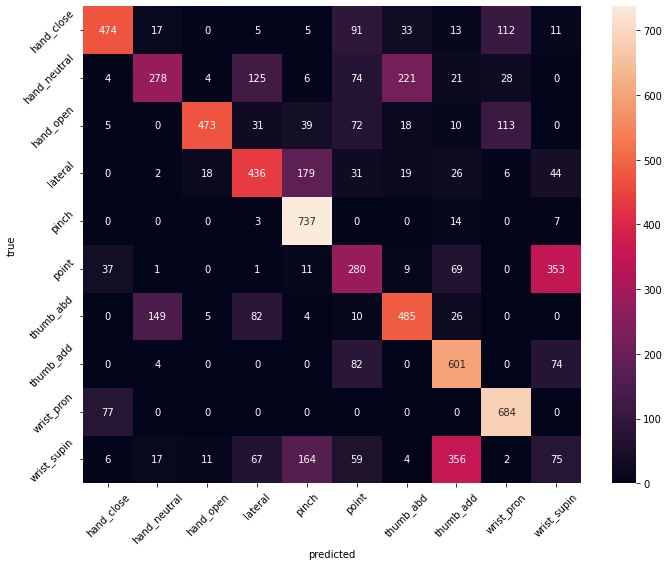

In [81]:
preds = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, preds)
fig = plt.figure(figsize = (10, 8))
sns.heatmap(cf_matrix, annot=True, fmt=".0f")
plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.ylabel("true")
plt.xlabel("predicted")
plt.tight_layout()

In [ ]:
take 3 rerecord - open, pronation, thumb adduction

In [33]:
df_sub[df_sub["take"] == 2].gesture.value_counts()

hand_neutral    410
hand_close      378
hand_open       354
lateral          95
thumb_add        68
wrist_supin      50
thumb_abd        22
pinch            20
point            20
Name: gesture, dtype: int64

In [181]:
import numpy as np
df_sub = df[df.subject == "Joel"]
results = np.zeros((5, 8))
# train test split 
for test_set in range(1,9):
    for idx, fraction in enumerate(np.arange(0.1, 1, 0.2)):
        df_train = df_sub[df_sub["take"] != test_set]
        df_test = df_sub[df_sub["take"] == test_set]
        df_train = df_train.groupby('gesture', group_keys=False).apply(lambda x: x.sample(frac=fraction))
        print(df_train.shape)
        gestures = df_train.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)

        # train xgb model 
        model = GestureRecognitionModel("xgboost")
        model.train(X_train,y_train)
        acc = model.evaluate(X_test, y_test)
        results[idx, test_set-1] = acc




(3321, 60)
(9961, 60)
(16603, 60)
(23241, 60)
(29881, 60)
(3379, 60)
(10142, 60)
(16905, 60)
(23665, 60)
(30427, 60)
(3494, 60)
(10481, 60)
(17468, 60)
(24452, 60)
(31439, 60)
(3494, 60)
(10484, 60)
(17475, 60)
(24460, 60)
(31450, 60)
(3416, 60)
(10250, 60)
(17084, 60)
(23914, 60)
(30748, 60)
(3352, 60)
(10056, 60)
(16761, 60)
(23462, 60)
(30166, 60)
(3361, 60)
(10088, 60)
(16815, 60)
(23539, 60)
(30265, 60)
(3476, 60)
(10425, 60)
(17375, 60)
(24322, 60)
(31271, 60)


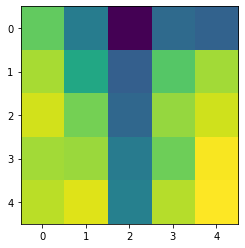

In [200]:
plt.imshow(results)
results1 = results[:, [0, 1, 2, 6, 7]]
plt.imshow(results1)

Text(0, 0.5, 'accuracy')

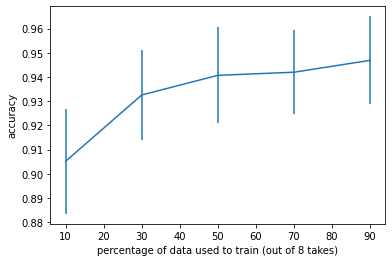

In [201]:
m = results1.mean(axis = 1)
s = results1.std(axis = 1)
plt.errorbar(y = m, x = range(10, 100, 20), yerr = s)
plt.xlabel("percentage of data used to train (out of 8 takes)")
plt.ylabel("accuracy")

array([[0.94036831],
       [0.95001462],
       [0.95556855],
       [0.94942999],
       [0.95235311]])

In [188]:
s

array([0., 0., 0., 0., 0.])

In [145]:
model.evaluate(X_test, y_test)

0.9493548387096774

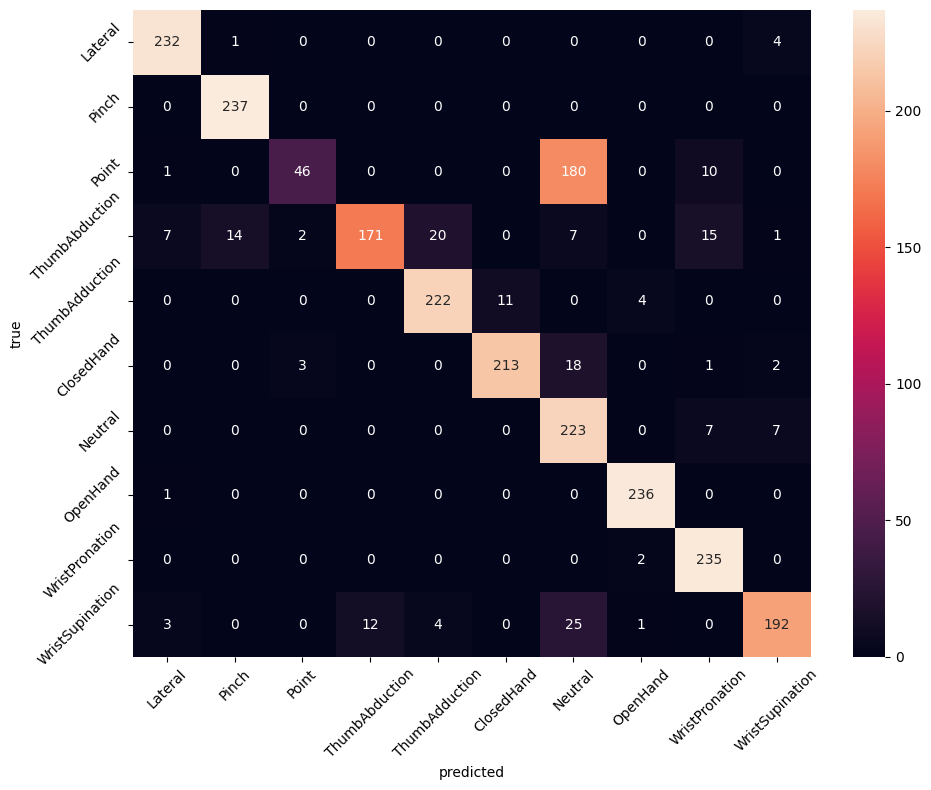

In [15]:
preds = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, preds)
fig = plt.figure(figsize = (10, 8))
sns.heatmap(cf_matrix, annot=True, fmt=".0f")
plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.ylabel("true")
plt.xlabel("predicted")
plt.tight_layout()

In [16]:
accuracy = dict()

for gesture in df_test.gesture.unique():
    print(gesture)
    accumulate = None
    df_sub_gesture = df_test[df_test.gesture == gesture]
    for iteration in df_sub_gesture.iteration.unique():
        df_sub_time = df_sub_gesture[df_sub_gesture.iteration == iteration]
        X_test = df_sub_time[features_to_keep]
        preds = model.predict(X_test)
        acc = (preds==gesture_to_int[gesture])
        acc = np.array([int(i) for i in acc])
        if accumulate is None:
            accumulate = acc
            size = len(accumulate)
        if len(acc) < size:
            accumulate = accumulate[:len(acc)]
            size = len(accumulate)
        
        accumulate += np.array(acc[:size])
    accuracy[gesture] = accumulate

Lateral
Pinch
Point
ThumbAbduction
ThumbAdduction
ClosedHand
Neutral
OpenHand
WristPronation
WristSupination


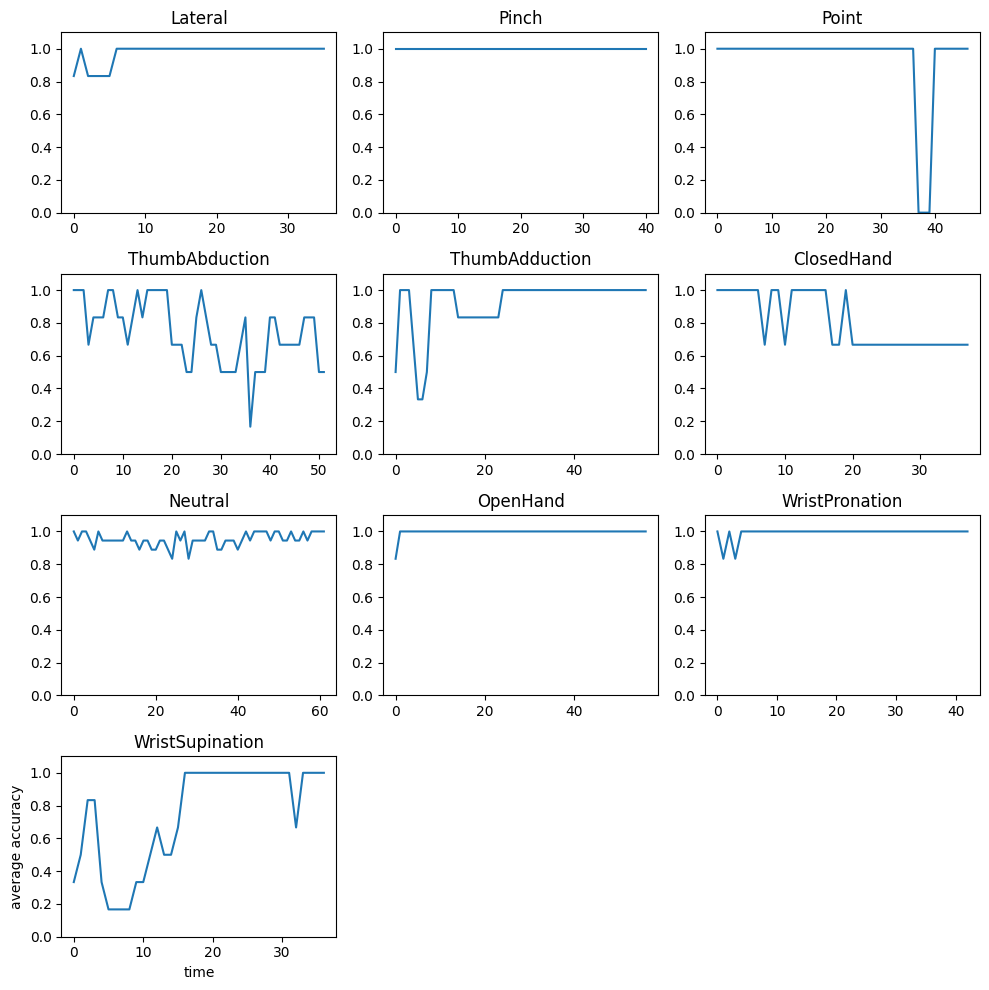

In [17]:
plt.figure(figsize=(10,10))
for i, gesture in enumerate(accuracy):
    plt.subplot(4,3, i+1)
    factor = max(accuracy[gesture])
    plt.plot(accuracy[gesture]/factor)
    plt.ylim((0, 1.1))
    plt.title(gesture)
plt.ylabel("average accuracy")
plt.xlabel("time")
plt.tight_layout()

In [1]:
from Signal import Signal


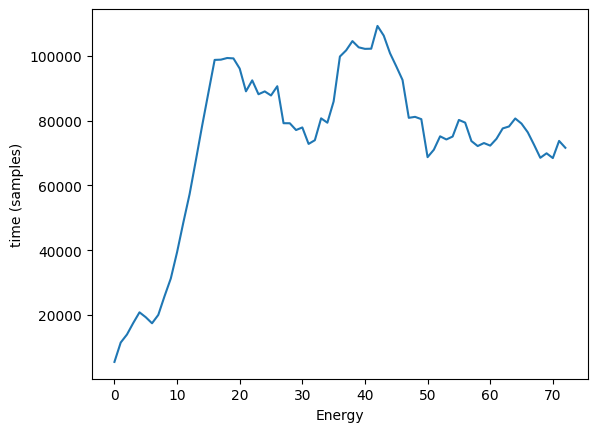

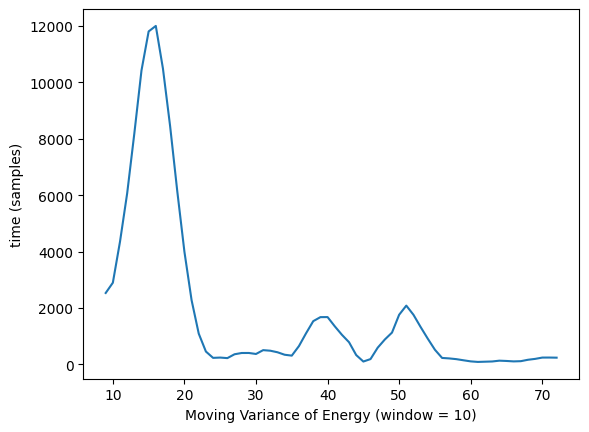

In [64]:
signal = Signal("../data/Joel1/ThumbAdduction_3.npy")
signal.display()
signal.display("sliding_var_energy", 10)

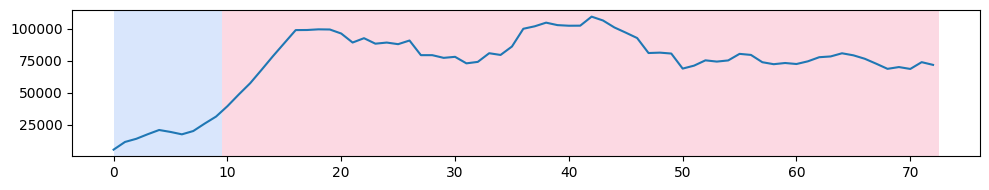

In [65]:


s = signal.get_features(list_features=["mav"]).sum(axis=1)
# detection
algo = rpt.Binseg(model="l2").fit(s)
result = algo.predict(n_bkps=1)

# display
rpt.display(s, result)
plt.show()

In [66]:
result

[10, 73]

In [41]:
import matplotlib.pyplot as plt
import ruptures as rpt
import bottleneck as bn
files = ["ClosedHand_2", "ClosedHand_4", 
        "OpenHand_2", "OpenHand_3",
        "WristSupination_0", "WristSupination_3", 
        "WristPronation_1", "WristPronation_4", 
        "Lateral_1", "Lateral_2", 
        "Point_3", "Point_4",
        "Pinch_3", "Pinch_4", 
        "ThumbAbduction_3", "ThumbAbduction_4",
        "ThumbAdduction_3", "ThumbAdduction_4"]

for i, file in enumerate(files):
        signal = Signal(f"../data/Joel1/{file}.npy")
        s = signal.get_features(list_features=["mav"]).sum(axis=1)
        # detection
        algo = rpt.Binseg(model="l2").fit(s)
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(s, result)
        plt.title(file)
        plt.show()



[5, 72]